In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [3]:
inputFile = "training_data/labels.txt"

def one_hot_encode_amino_acids(input_string):
    
    amino_acid_mapping = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

    one_hot_array = np.zeros((len(input_string), len(amino_acid_mapping)))
    
    for i in range(len(input_string)):
        try:
            one_hot_array[i, [amino_acid_mapping[input_string[i]]]] = 1
        except:
            one_hot_array = one_hot_array[:-1]
        
    return one_hot_array

def decode_one_hot_array(array):
    reverse_mapping = {0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}
    
    indices_array = np.argmax(array, axis=1)
    
    string = ''
    for i in range(array.shape[0]):
        string += reverse_mapping[indices_array[i]]
    
    return string

def encode_helices(input_string):
    array = np.zeros((len(input_string),))
    
    for i in range(len(input_string)):
        if input_string[i] == 'H':
            array[i] = 1
        elif input_string[i] == '-':
            array[i] = 0
        else:
            array = array[:-1]
    
    return array

def decode_helices(array):
    string = ''
    
    for i in range(array.shape[0]):
        if array[i] == 1:
            string += 'H'
        else:
            string += '-'
            
    return string


labels = []
sequences = []

seq_strings = []
label_strings = []

with open(inputFile, 'r') as f:
    while True:
        
        name = f.readline()
        sequence = f.readline()
        label = f.readline()
        
        if not label: break
        
        labels.append(encode_helices(label[:-1]))
        sequences.append(one_hot_encode_amino_acids(sequence[:-1]))
        
        seq_strings.append(sequence[:-1])
        label_strings.append(label[:-1])

In [4]:
def create_windows_dataset(sequences, labels, window_size):
    pad_length = (window_size-1)//2
    
    dataset_sequences = []
    dataset_labels = []
    
    for i in range(len(sequences)):
        seq = np.pad(sequences[i], ((pad_length, pad_length), (0, 0)))
        lab = labels[i]
        
        for j in range(sequences[i].shape[0]):
            dataset_sequences.append(seq[j:j+window_size])
            dataset_labels.append(lab[j])

    return np.array(dataset_sequences), np.array(dataset_labels)

In [99]:
from sklearn.naive_bayes import MultinomialNB

windows = [3, 5, 7, 9, 11, 13, 15, 21, 27, 35]

accuracies = []

for window in windows:
    
    X, Y = create_windows_dataset(sequences, labels, window)
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Initialize Gaussian Naive Bayes model
    model = MultinomialNB()

    # Train the model
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for window size {window}: {accuracy:.2f}")
    
    accuracies.append(accuracy)

Accuracy for window size 3: 0.66
Accuracy for window size 5: 0.69
Accuracy for window size 7: 0.70
Accuracy for window size 9: 0.71
Accuracy for window size 11: 0.72
Accuracy for window size 13: 0.72
Accuracy for window size 15: 0.72
Accuracy for window size 21: 0.72
Accuracy for window size 27: 0.72
Accuracy for window size 35: 0.72


Text(0, 0.5, 'Accuracy')

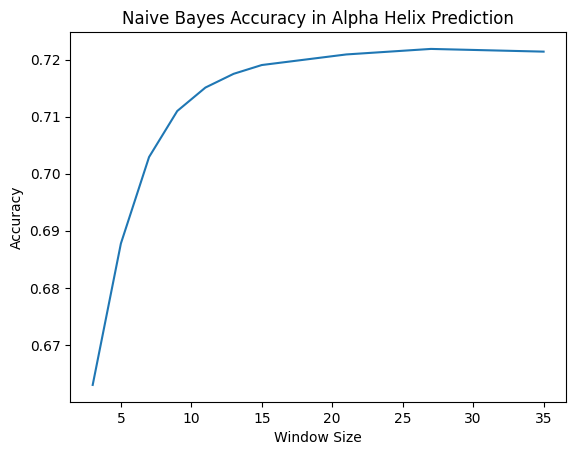

In [100]:
plt.plot(windows, accuracies)
plt.title('Naive Bayes Accuracy in Alpha Helix Prediction')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')

In [318]:
seq_train, seq_test, labels_train, labels_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [319]:
X_train, y_train = create_windows_dataset(seq_train, labels_train, 11)
X_test, y_test = create_windows_dataset(seq_test, labels_test, 11)

In [320]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])


mnb = MultinomialNB()

# Train the model
mnb.fit(X_train, y_train)

class_log_prior = mnb.class_log_prior_
feature_log_prob = mnb.feature_log_prob_

In [199]:
feature_log_prob_new = []
for i in range(2):
    feature_log_prob_new.append(list(feature_log_prob[i, :]))

In [200]:
import ast

file_path = 'src/parameters.txt'
with open(file_path, 'w') as file:
    file.write(str(list(class_log_prior)) + '\n')
    file.write(str(feature_log_prob_new) + '\n')

In [344]:
with open(file_path, 'r') as f:
    class_log_prior = np.array(ast.literal_eval(f.readline()[:-1]))
    feature_log_prob = np.array(ast.literal_eval(f.readline()[:-1]))
    
    W_lstm = np.array(ast.literal_eval(f.readline()[:-1]))
    U_lstm = np.array(ast.literal_eval(f.readline()[:-1]))
    b_lstm = np.array(ast.literal_eval(f.readline()[:-1]))
    
    W_dense = np.array(ast.literal_eval(f.readline()[:-1]))
    b_dense = np.array(ast.literal_eval(f.readline()[:-1]))

In [204]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probabilities

def GNB_probabilities(input_array, feature_log_prob, class_log_prior):
    log_likelihoods = np.dot(input_array, feature_log_prob.T) + class_log_prior
    output = (softmax(log_likelihoods))[:, 1] # Take the softmax of the log likelihoods, and take the probability of alpha helix, which is column 1
    # Since this is only binary classification, but the trained model on sklearn made predictions as 2 classes 
    return output

In [321]:
X_train = GNB_probabilities(X_train, feature_log_prob, class_log_prior)
X_test = GNB_probabilities(X_test, feature_log_prob, class_log_prior)

In [322]:
X_test_GNB = X_test.reshape(-1, 1)

start = 0
for i in range(len(seq_test)):
    length = seq_test[i].shape[0]
    seq_test[i] = np.concatenate((seq_test[i], X_test_GNB[start: start+length, :]), axis=1)
    
    start += length

In [298]:
def convert_NB_to_lstm_data(seq, X, y, max_len):
    start = 0
    num_values = seq[0].shape[1] + 1
    new_x = np.zeros((len(seq), max_len, num_values))
    new_y = np.zeros((len(seq), max_len))
    
    for i in range(len(seq)):
        seq_length = seq[i].shape[0]
        if seq_length < max_len:
            new_x[i, :seq_length, :num_values-1] = seq[i]
            new_x[i, :seq_length, num_values-1] = X[start: start+seq_length]
            new_y[i, :seq_length] = y[start: start+seq_length]
        else:
            new_x[i, :seq_length, :num_values-1] = seq[i][:max_len, :]
            new_x[i, :max_len, num_values-1] = X[start: start+max_len]
            new_y[i, :max_len] = y[start: start+max_len]
        start += seq_length
    
    return new_x, new_y.reshape(new_y.shape[0], new_y.shape[1], 1)

def convert_list_to_lstm_array(seq, max_len):
    new_x = np.zeros((len(seq), max_len, seq[0].shape[1]))
    
    for i in range(len(seq)):
        seq_length = seq[i].shape[0]
        if seq_length<max_len:
            new_x[i, :seq_length, :] = seq[i]
        else:
            new_x[i, :seq_length, :] = seq[i][:max_len, :]
    
    return new_x

In [299]:
X_train_lstm, y_train_lstm = convert_NB_to_lstm_data(seq_train, X_train, y_train, 1419)
X_test_lstm, y_test_lstm = convert_NB_to_lstm_data(seq_test, X_test, y_test, 1419)

In [208]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# Build the model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None,21)))
model.add(LSTM(64, return_sequences=True))  # Set return_sequences=True
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to store training and validation accuracy for each epoch
class AccuracyHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

# Instantiate the callback
accuracy_history = AccuracyHistory()

# Train the model with validation data and using the callback
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=21,
    batch_size=8,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[accuracy_history]
)

Epoch 1/21


2023-11-26 15:10:50.357284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 15:10:50.777863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 15:10:51.238171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.6936

2023-11-26 15:11:56.530860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 15:11:56.744855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - 75s 137ms/step - loss: 0.5870 - accuracy: 0.6936 - val_loss: 0.5586 - val_accuracy: 0.7187
Epoch 2/21
533/533 [==============================] - 71s 134ms/step - loss: 0.5543 - accuracy: 0.7210 - val_loss: 0.5571 - val_accuracy: 0.7186
Epoch 3/21
533/533 [==============================] - 71s 134ms/step - loss: 0.5450 - accuracy: 0.7265 - val_loss: 0.5411 - val_accuracy: 0.7304
Epoch 4/21
533/533 [==============================] - 71s 134ms/step - loss: 0.5370 - accuracy: 0.7310 - val_loss: 0.5361 - val_accuracy: 0.7331
Epoch 5/21
533/533 [==============================] - 72s 135ms/step - loss: 0.5307 - accuracy: 0.7357 - val_loss: 0.5305 - val_accuracy: 0.7365
Epoch 6/21
533/533 [==============================] - 72s 134ms/step - loss: 0.5236 - accuracy: 0.7405 - val_loss: 0.5272 - val_accuracy: 0.7394
Epoch 7/21
533/533 [==============================] - 72s 135ms/step - loss: 0.5208 - accuracy: 0.7419 - val_loss: 0.5359 - val_accuracy: 0.7

In [223]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

In [341]:
def lstm_cell(X_t, h_prev, c_prev, W, U, b, units=64):
    # Weight matrix of current LSTM unit
    W_i = W[:, :units] # input gate
    W_f = W[:, units: units * 2] # forget gate 
    W_c = W[:, units * 2: units * 3] # cell state
    W_o = W[:, units * 3:] # forget gate

    # Weight matrix connecting previous LSTM unit to current
    U_i = U[:, :units]
    U_f = U[:, units: units * 2]
    U_c = U[:, units * 2: units * 3]
    U_o = U[:, units * 3:]

    # Bias vectors 
    b_i = b[:units]
    b_f = b[units: units * 2]
    b_c = b[units * 2: units * 3]
    b_o = b[units * 3:]
    
    
    # Input gate
    i_t = sigmoid(X_t @ W_i + h_prev @ U_i + b_i)
    
    # Forget gate
    f_t = sigmoid(X_t @ W_f + h_prev @ U_f + b_f)
    
    # Cell state
    c_t = f_t * c_prev + i_t * tanh(X_t @ W_c + h_prev @ U_c + b_c)
    
    # Output gate
    o_t = sigmoid(X_t @ W_o + h_prev @ U_o + b_o)
    
    # Hidden state
    h_t = o_t * tanh(c_t)
    
    return h_t, c_t

def dense_layer(input_data, w_dense, b_dense):
    output = input_data@w_dense + b_dense
    return output

def forward_propagation(sequence,  W_lstm, U_lstm, b_lstm, W_dense, b_dense, units=64):
    c_t = np.zeros((1, units))
    h_t = np.zeros((1, units))
    
    preds = np.zeros((len(sequence)))
    for i in range(sequence.shape[0]):
        h_t, c_t = lstm_cell(sequence[i,:], h_t, c_t, W_lstm, U_lstm, b_lstm)
        
        value = dense_layer(h_t, W_dense, b_dense)

        binary_output = 1 if value > 0.5 else 0
        
        preds[i] = binary_output
        
    return preds

In [346]:
sum_total = 0
sum_correct = 0
for i in range(len(seq_test)):
    preds = forward_propagation(seq_test[i], W_lstm, U_lstm, b_lstm, W_dense, b_dense)
    
    excess = X_test_lstm.shape[1] - seq_test[i].shape[0]
    sum_total += seq_test[i].shape[0]
    sum_correct += np.sum(preds == y_test_lstm[i, :seq_test[i].shape[0], 0])
    
sum_correct/sum_total

0.7581283748364522

In [342]:
W_lstm_temp = []
for i in range(W_lstm.shape[0]):
    W_lstm_temp.append(list(W_lstm[i, :]))
W_lstm = W_lstm_temp

U_lstm_temp = []
for i in range(U_lstm.shape[0]):
    U_lstm_temp.append(list(U_lstm[i, :]))
U_lstm = U_lstm_temp

b_lstm = list(b_lstm)

W_dense_temp = []
for i in range(W_dense.shape[0]):
    W_dense_temp.append(list(W_dense[i, :]))
W_dense = W_dense_temp

b_dense = list(b_dense)

In [343]:
file_path = 'src/parameters.txt'
with open(file_path, 'w') as file:
    file.write(str(list(class_log_prior)) + '\n')
    file.write(str(feature_log_prob_new) + '\n')
    
    file.write(str(W_lstm) + '\n')
    file.write(str(U_lstm) + '\n')
    file.write(str(b_lstm) + '\n')
    
    file.write(str(W_dense) + '\n')
    file.write(str(b_dense) + '\n')

In [91]:
test_size = 0.3
validation_size = 0.2
x_lstm_seq, x_temp, y_lstm_seq, y_temp = train_test_split(sequences, labels, test_size=test_size + validation_size, random_state=42)
x_test_seq, x_NB1, y_test_seq, y_NB1 = train_test_split(x_temp, y_temp, test_size=test_size/(test_size + validation_size), random_state=42)

In [92]:
x_NB1, y_NB1 = create_windows_dataset(x_NB1, y_NB1, 13)

X_test, y_test = create_windows_dataset(x_test_seq, y_test_seq, 13)

X_lstm, y_lstm = create_windows_dataset(x_lstm_seq, y_lstm_seq, 13)

In [93]:
X_train_NB = x_NB1.reshape(x_NB1.shape[0], x_NB1.shape[1]*x_NB1.shape[2])
X_lstm_NB = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1]*X_lstm.shape[2])
X_test_NB = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])


gnb2 = GaussianNB()

# Train the model
gnb2.fit(X_train_NB, y_NB1)

GaussianNB()

In [94]:
X_train_NB_lstm = (gnb2.predict_proba(X_lstm_NB))[:,1]
X_test_NB = (gnb2.predict_proba(X_test_NB))[:, 1]

In [95]:
X_train_lstm, y_train_lstm = convert_NB_to_lstm_data(x_lstm_seq, X_train_NB_lstm, y_lstm, 500)
X_test_lstm, y_test_lstm = convert_NB_to_lstm_data(x_test_seq, X_test_NB, y_test, 500)

In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# Build the model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(None,21)))
model.add(LSTM(64, return_sequences=True))  # Set return_sequences=True
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with validation data and using the callback
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=25,
    batch_size=8,
    validation_data=(X_test_lstm, y_test_lstm)
)

Epoch 1/25


2023-11-26 10:49:37.104679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 10:49:37.437266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 10:49:37.772865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


333/333 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6820

2023-11-26 10:49:56.712967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 10:49:56.888762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


333/333 [==============================] - 24s 68ms/step - loss: 0.6019 - accuracy: 0.6820 - val_loss: 0.5915 - val_accuracy: 0.6966
Epoch 2/25
333/333 [==============================] - 22s 65ms/step - loss: 0.5790 - accuracy: 0.7049 - val_loss: 0.5835 - val_accuracy: 0.7015
Epoch 3/25
333/333 [==============================] - 22s 65ms/step - loss: 0.5721 - accuracy: 0.7098 - val_loss: 0.5749 - val_accuracy: 0.7089
Epoch 4/25
333/333 [==============================] - 22s 66ms/step - loss: 0.5668 - accuracy: 0.7134 - val_loss: 0.5708 - val_accuracy: 0.7102
Epoch 5/25
333/333 [==============================] - 22s 66ms/step - loss: 0.5631 - accuracy: 0.7163 - val_loss: 0.5760 - val_accuracy: 0.7079
Epoch 6/25
333/333 [==============================] - 22s 66ms/step - loss: 0.5615 - accuracy: 0.7167 - val_loss: 0.5622 - val_accuracy: 0.7164
Epoch 7/25
333/333 [==============================] - 22s 66ms/step - loss: 0.5591 - accuracy: 0.7190 - val_loss: 0.5810 - val_accuracy: 0.6979
Epo